In [ ]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install


/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
0.6

--------------

0.65

--------------

0.7000000000000001

--------------

0.7500000000000001

--------------

0.8000000000000002

--------------

0.8500000000000002

--------------

0.9000000000000002

--------------

0.9500000000000003

--------------

{'rmse': [1606248.842766281, 1603187.1267668193, 1606847.3570643764, 1606605.024802226, 1603972.8111215176, 1604354.2542983328, 1606636.8603184076, 1610167.010161038], 'rmsle': [0.6048204944496296, 0.6041038131879247, 0.6047148890904327, 0.6052996001297815, 0.6051982916995223, 0.6047801126897351, 0.6065212585218971, 0.6043709455115688], 'percentage_of_train_cases': [0.6, 0.65, 0.7000000000000001, 0.7500000000000001, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.9500000000000003], 'time': [0.1544022560119629, 0.12067890167236328, 0.10903310775756836, 0.14000844955444336, 0.14603209495544434, 0.11519861221313477, 0.11106300354003906, 0.1360244750

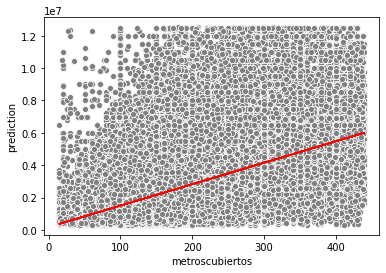

In [3]:

import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *

!pwd
!python --version
import metnum

def calculate_metrics(variable_to_predict, df):
    df = df[df['prediction'].notna()]
    return (math.sqrt(mean_squared_error(df[variable_to_predict], df['prediction'])),
            math.sqrt(mean_squared_log_error(df[variable_to_predict]+1, df['prediction']+1)))


def experiment(percentage_of_training_cases,
         variable_to_predict,
         variables_to_study,
         seed, 
         df_old,
         data):
    
    df = df_old.copy(deep=True)
        
    t0 = time.time()
    
    TOTAL_TRAIN_CASES = int(percentage_of_training_cases*len(df))

    df = df[0:].sample(frac=1, random_state=seed)
    
    df_prediction = df[TOTAL_TRAIN_CASES:].copy(deep=True)

    df = df[:TOTAL_TRAIN_CASES]

    x_train, y_train = df[variables_to_study].values, df[variable_to_predict].values
    x_predict, y_predict = df_prediction[variables_to_study].values, df_prediction[variable_to_predict].values
    
    x_train = x_train.reshape(len(x_train),len(variables_to_study))
    y_train = y_train.reshape(len(y_train),1)
    x_predict = x_predict.reshape(len(x_predict),len(variables_to_study))
    y_predict = y_predict.reshape(len(y_predict),1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x_train, y_train)
    df_prediction['prediction'] = linear_regressor.predict(x_predict)

    t1 = time.time()
    total_time = (t1-t0)
    
    rmse, rmsle = calculate_metrics(variable_to_predict, df_prediction)
    data['rmse'].append(rmse)
    data['rmsle'].append(rmsle)
    data['percentage_of_train_cases'].append(percentage_of_training_cases)
    data['time'].append(total_time)
    
    if(len(variables_to_study)==1):
        sns.scatterplot(data=df, x=variables_to_study[0], y=variable_to_predict)
        sns.lineplot(data=df_prediction, x=variables_to_study[0], y='prediction', color='red')
    elif(len(variables_to_study)==2):
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('X', fontsize=15, rotation=150)
        ax.set_ylabel('Y')
        ax.set_zlabel(r'Z', fontsize=15)
        ax.scatter(df_prediction[variables_to_study[0]],
                   df_prediction[variables_to_study[1]],
                   df_prediction['prediction'], c='skyblue', s=60)
        ax.plot_trisurf(df_prediction[variables_to_study[0]], 
                        df_prediction[variables_to_study[1]], 
                        df_prediction['prediction'], cmap=plt.cm.viridis, linewidth=0.2)
        plt.show()
    return df_prediction
    
df = pd.read_csv('../data/train.csv')


variable_to_predict = 'precio'
variables_to_study = ['metroscubiertos']

#cleanup
df = df[df[variable_to_predict].notna()]
for var in variables_to_study:
    df = df[df[var].notna()]

d = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}

folder='./test_m2_vs_precios_{}'.format(int(time.time()))

os.mkdir(folder)

for i in np.arange(0.6, 0.99, 0.05):
    print(i)
    df_prediction = experiment(i, variable_to_predict, variables_to_study, 666, df, d)
    df_prediction.to_csv(folder+'/prediction_m2_piscinas'+'_'+str(i)+'.csv', encoding='utf-8', index=False)
    print('\n--------------\n')
    
print(d)

(pd.DataFrame(data=d)
   .to_csv(folder+'/error_ms_vs_precios.csv', encoding='utf-', index=False))
